In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM

In [2]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('hanoi_quality.csv')
df1=df.reset_index()['pm25']

In [3]:
df1.shape

(1920,)

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [5]:
df1.shape

(1920, 1)

In [6]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]


In [7]:
print(train_size)
print(test_size)

1728
192


In [8]:
print(train_data.shape)
print(test_data.shape)


(1728, 1)
(192, 1)


In [9]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [10]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [11]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(ytest.shape)


(1627, 100)
(1627,)
(91, 100)
(91,)


In [12]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)


In [13]:
print(X_train.shape)
print(X_test.shape)

(1627, 100, 1)
(91, 100, 1)


In [14]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 76s 852ms/step - loss: 0.0476 - val_loss: 0.0295
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 30s 387ms/step - loss: 0.0218 - val_loss: 0.0322
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 441ms/step - loss: 0.0202 - val_loss: 0.0298
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 320ms/step - loss: 0.0219 - val_loss: 0.0301
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 333ms/step - loss: 0.0191 - val_loss: 0.0297
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 340ms/step - loss: 0.0208 - val_loss: 0.0292
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 356ms/step - loss: 0.0219 - val_loss: 0.0294
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 341ms/step - loss: 0.0204 - val_loss: 0.0286
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 408ms/step - loss: 0.0196 - val_loss: 0.0285
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 242ms/step - loss: 0.0194 - val_loss: 0.0279
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 402ms/step - loss: 0.0185 - val_loss: 0.0265
Epoch 12/100
26/26 ━━━━━━━━━━━━

In [16]:
X_test.shape

(91, 100, 1)

In [17]:
# 10. Dự báo dữ liệu test,
train_predict=model.predict(X_train)
y_pred=model.predict(test_data.reshape(test_data.shape[0],test_data.shape[1] , 1))


51/51 ━━━━━━━━━━━━━━━━━━━━ 22s 291ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step


In [18]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)


In [19]:
test_data.shape

(192, 1)

In [20]:
y_pred.shape

(192, 1)

In [21]:
ytest=scaler.inverse_transform(test_data)
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

# Đánh giá độ chính xác thuật toán bằng MAPE
test_mape = np.mean(np.abs(ytest - y_pred)/np.abs(ytest))*100

print('Testing MAPE:', test_mape)

# Đánh giá độ chính xác thuật toán bằng MAE
test_mae = np.mean(abs(y_pred - ytest))
print('Testing MAE:', test_mae)

Testing RMSE: 49.47096451123172
Testing MAPE: 50.97714581908459
Testing MAE: 45.51974896589915


In [22]:
x_input=test_data[60:].reshape(1,-1)
x_input.shape

(1, 132)

In [23]:
# 13. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
print(x_input.shape)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=132
i=0
while(i<90):

    if(len(temp_input)>132):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


(1, 132)
[0.38969567]
133
1 day input [0.51627907 0.31162791 0.40930233 0.53023256 0.51162791 0.40465116
 0.53488372 0.73488372 0.80465116 0.78139535 0.66511628 0.28837209
 0.26976744 0.29767442 0.35813953 0.34418605 0.26511628 0.29302326
 0.65116279 0.41395349 0.51627907 0.28372093 0.26511628 0.37209302
 0.53953488 0.40465116 0.30697674 0.25581395 0.33953488 0.35348837
 0.31627907 0.4372093  0.16744186 0.16744186 0.27906977 0.20930233
 0.39069767 0.24651163 0.20465116 0.38139535 0.58139535 0.66511628
 0.90697674 0.76744186 0.6        0.78139535 0.70697674 0.29302326
 0.33488372 0.67906977 0.53953488 0.37674419 0.49767442 0.33023256
 0.3627907  0.30697674 0.29302326 0.4        0.59534884 0.51162791
 0.34418605 0.3255814  0.3255814  0.33023256 0.42325581 0.40465116
 0.4744186  0.46976744 0.49767442 0.53953488 0.46976744 0.51162791
 0.45581395 0.31162791 0.28372093 0.29302326 0.2        0.35813953
 0.45116279 0.39069767 0.3255814  0.24651163 0.28837209 0.10232558
 0.74418605 0.11162791 0

In [24]:
print(x_input.shape)


(1, 132, 1)


In [25]:
print(test_data.shape)

(192, 1)


In [26]:
test_data.shape

(192, 1)

In [27]:
y_pred.shape

(192, 1)

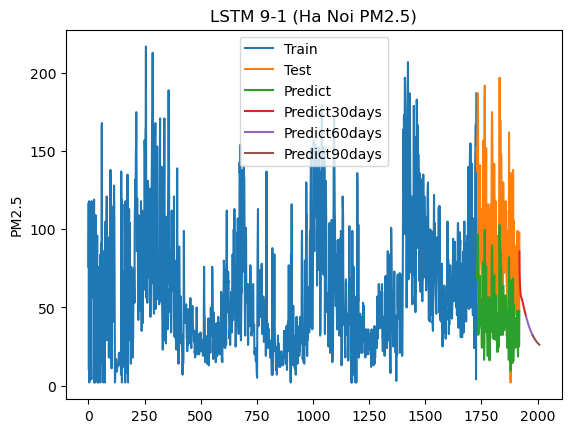

In [31]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,y_pred)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[0:30]))

prediect_data_index = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[30:60]))

prediect_data_index = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[60:90]))
plt.legend(['Train','Test','Predict','Predict30days', 'Predict60days', 'Predict90days'])
plt.title('LSTM 9-1 (Ha Noi PM2.5)')
plt.ylabel('PM2.5')
plt.show()

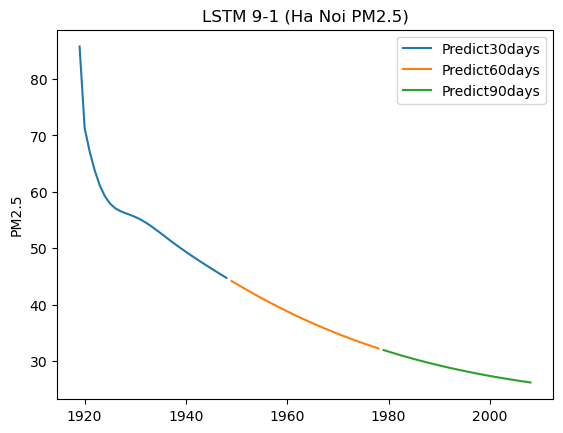

In [32]:
# 14.Vẽ hình
# Dự đoán 90 ngày tiếp theo

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[0:30]))

prediect_data_index = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[30:60]))

prediect_data_index = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[60:90]))
plt.legend(['Predict30days', 'Predict60days', 'Predict90days'])
plt.title('LSTM 9-1 (Ha Noi PM2.5)')
plt.ylabel('PM2.5')
plt.show()

In [30]:
print(scaler.inverse_transform(lst_output))

[[85.78456995]
 [71.31718618]
 [67.12707889]
 [63.77937195]
 [61.12128493]
 [59.21663013]
 [57.9355019 ]
 [57.11926979]
 [56.6032162 ]
 [56.23934713]
 [55.91312212]
 [55.54966633]
 [55.11137415]
 [54.58982293]
 [53.99568115]
 [53.34915486]
 [52.67260623]
 [51.98575114]
 [51.30339091]
 [50.63479719]
 [49.98445523]
 [49.35316597]
 [48.73944928]
 [48.14065245]
 [47.55398822]
 [46.9769865 ]
 [46.40790445]
 [45.84566881]
 [45.28989513]
 [44.74063148]
 [44.19828792]
 [43.66338027]
 [43.13641471]
 [42.61788462]
 [42.10814883]
 [41.60744441]
 [41.11592513]
 [40.63364547]
 [40.16060543]
 [39.69675374]
 [39.24203274]
 [38.79636873]
 [38.35969445]
 [37.9319362 ]
 [37.51302351]
 [37.1028987 ]
 [36.70148489]
 [36.30871479]
 [35.92451152]
 [35.54879178]
 [35.18147868]
 [34.82248251]
 [34.47169755]
 [34.12903731]
 [33.79438964]
 [33.46763921]
 [33.14868671]
 [32.83740398]
 [32.53368211]
 [32.23739934]
 [31.94844355]
 [31.66667697]
 [31.39198747]
 [31.12424371]
 [30.86332393]
 [30.60910639]
 [30.36146